# **Cell clustering and Differential Expression (DE)**

---------------------------

**Motivation:**

Spermatogenesis goes through different stages, starting from *SpermatogoniaA* cells, going into clonal expansion while keeping cells connected through cytoplasmic bridges (*SpermatogoniaB*), and then continuing with the meiotic process (*Spermatocites I and II*). Finally, cells become *Round spermatids*, which then elongate to become *Elongated spermatids and sperm*.

![](https://raw.githubusercontent.com/hds-sandbox/scRNASeq_course/main/develop/python/img/spermatogenesis.png)

Detecting those cell types is essential to answer biological questions such as 
- which genes are most expressed for each cell type (beyond well known ones)?
- in which proportion is every cell type present?
- are there unknown cell types that I can identify?

---------------------------

**Learning objectives:**
- Identify potential cell clusters by visualizing marker genes on the UMAP plot
- Understanding and applying differential gene expression analysis to verify cluster identities
- Performing an analysis of subclusters in the dataset
----------------
**Execution time: 45-60 minutes**

---------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

plt.rcParams['figure.figsize']=(6,6) #rescale figures

Read the data integrated with `glmpca` and `bbknn`

In [2]:
sample = sc.read('../../Data/notebooks_data/sample_123.filt.norm.red.h5ad')

Only considering the two last: ['.red', '.h5ad'].
Only considering the two last: ['.red', '.h5ad'].


## Identification through marker genes

we try to identify clusters of cells by looking at the expression of relevant marker genes. This requires a previous biological knowledge of those cell types, such that we can input the markers. Below, we define a dectionary, where for each cell type we define a list of markers. Then we will plot every list of markers on the UMAP plot

In [3]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2','PRM3','AKAP4'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD14']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

#remove markers missing in the dataset
for i in markers:
    markers[i] = np.intersect1d(markers[i], sample.var_names)

We can see how many markers easily identify groups of cells by plotting the expression

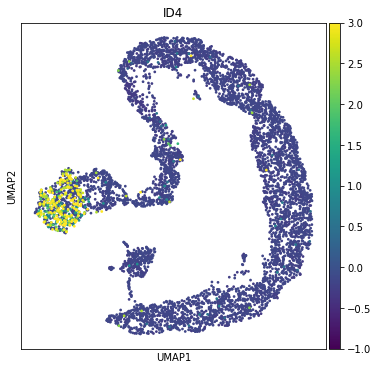

In [4]:
sc.plotting.umap(sample, color=markers['SpermatogoniaA'], vmin=-1, vmax=3, s=30)

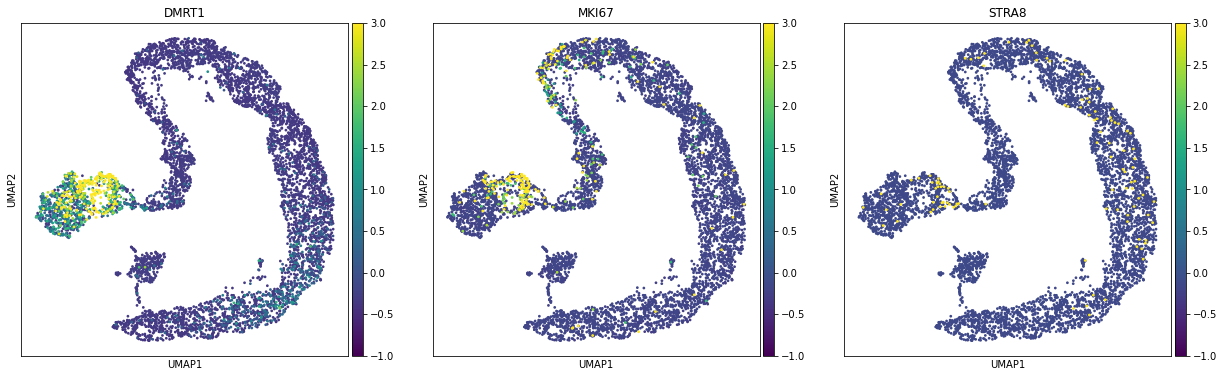

In [5]:
sc.plotting.umap(sample, color=markers['SpermatogoniaB'], vmin=-1, vmax=3, s=30)

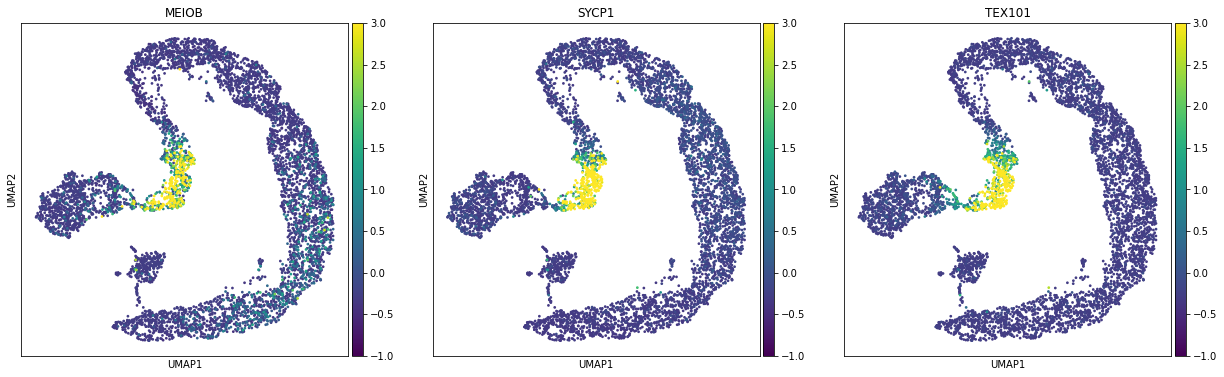

In [6]:
sc.plotting.umap(sample, color=markers['SpermatocytesI'], vmin=-1, vmax=3, s=30)

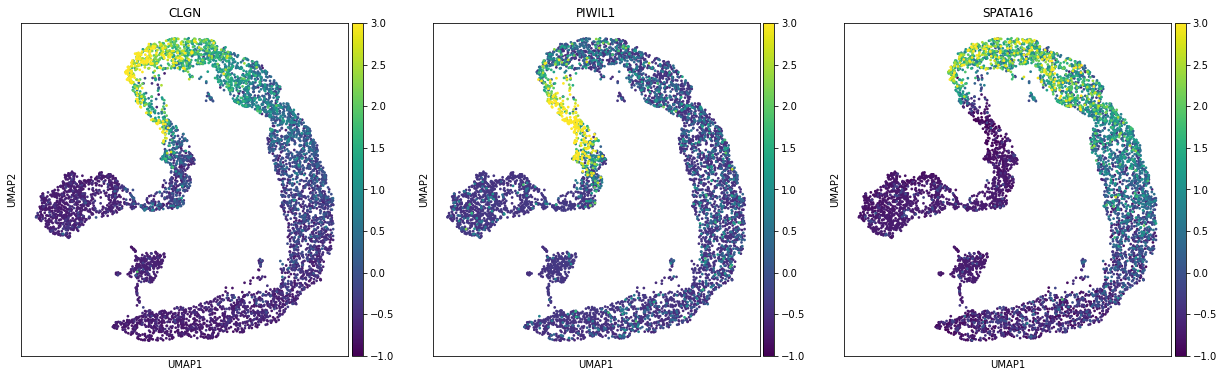

In [7]:
sc.plotting.umap(sample, color=markers['SpermatocytesII'], vmin=-1, vmax=3, s=30)

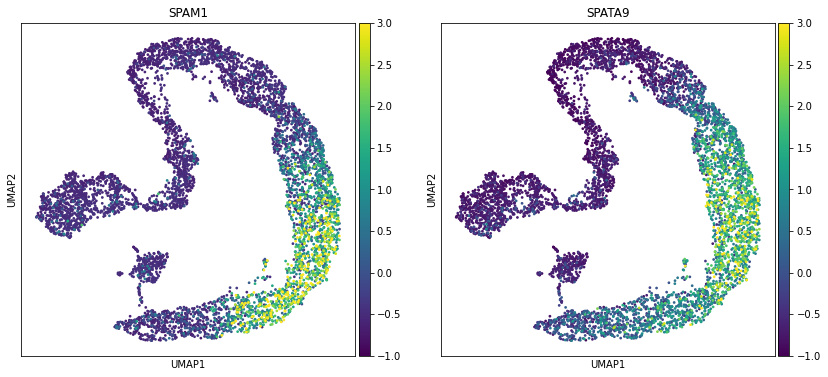

In [8]:
sc.plotting.umap(sample, color=markers['Round.Spt'], vmin=-1, vmax=3, s=30)

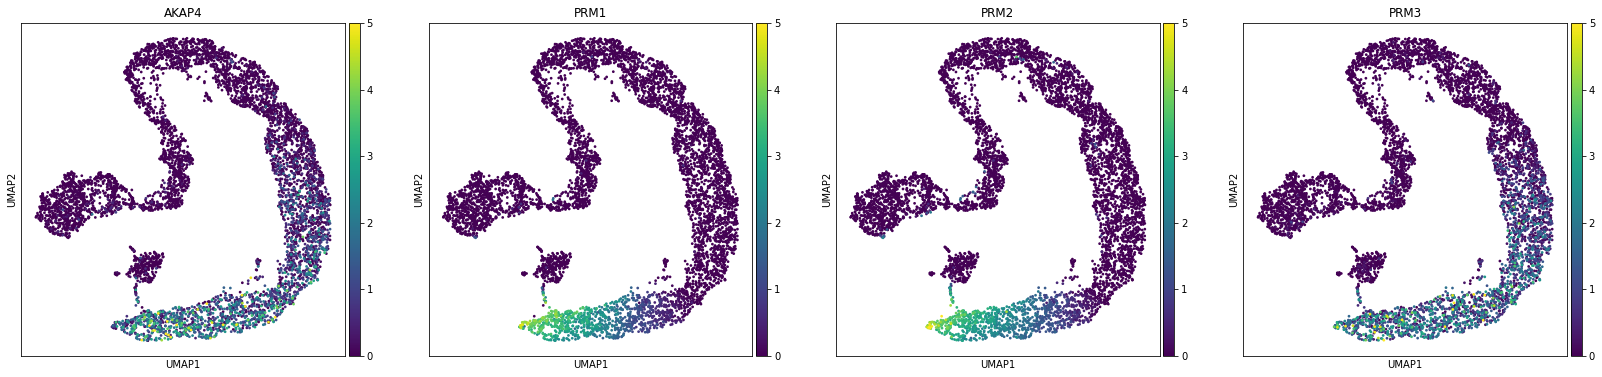

In [9]:
sc.plotting.umap(sample, color=markers['Elong.Spt'], vmin=0, vmax=5, s=30)

Sertoli are often not possible to identify. They are big in size, meaning they are often not isolated successfully. Many of their markers are in common with other somatic cells. Also, their function as nurse cells for germ cells of the testis means that their marker genes are also expressed. We can see that CTSL is expressed in some germ cells, but not in other clusters, while VIM is expressed in a likely somatic cluster (but it is common to other somatic cell types)

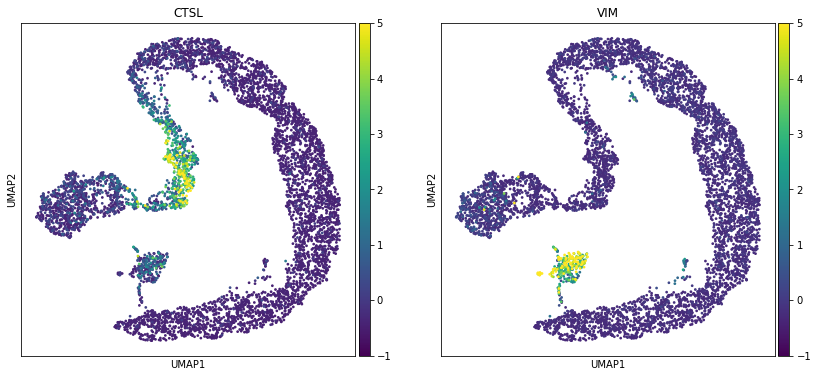

In [10]:
sc.plotting.umap(sample, color=markers['Sertoli'], vmin=-1, vmax=5, s=30)

Macrophage cells seem to be absent

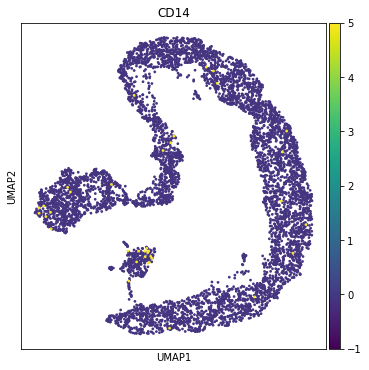

In [11]:
sc.plotting.umap(sample, color=markers['Macroph'], vmin=-1, vmax=5, s=30)

There is a little endothelial cluster

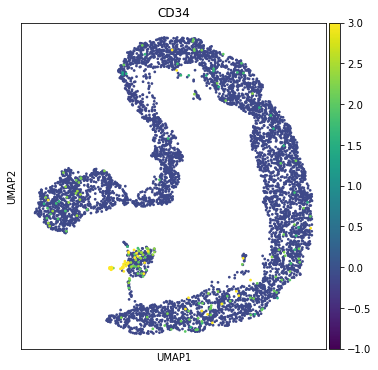

In [12]:
sc.plotting.umap(sample, color=markers['Endothelial'], vmin=-1, vmax=3, s=30)

and also a myoid cluster

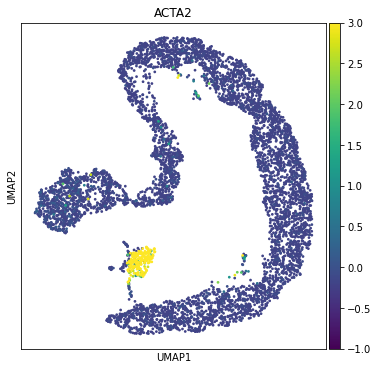

In [13]:
sc.plotting.umap(sample, color=markers['Myoid'], vmin=-1, vmax=3, s=30)

Leydig cells are likely to be missing as well

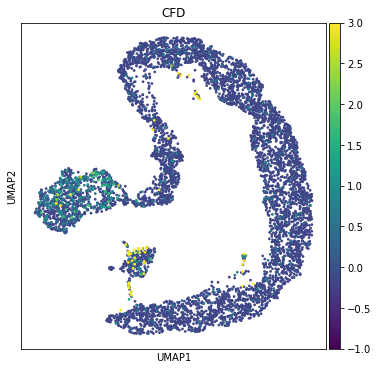

In [14]:
sc.plotting.umap(sample, color=markers['Leydig'], vmin=-1, vmax=3, s=30)

Now we create some clusters, and try to get the same division we saw by plotting markers. We can tune the number of clusters by changing the `resolution` parameter. We will be able to give the same name to more clusters, so it is fine to create a fine-grained clustering.

In [15]:
sc.tl.leiden(sample, resolution=.3, random_state=12345)

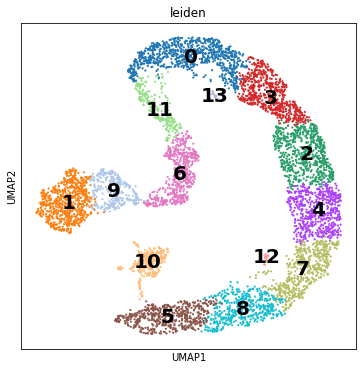

In [16]:
sc.plotting.umap(sample, color=['leiden'], legend_loc='on data', legend_fontsize=20)

Write the names in the dictionary `new_names`. You should be able to **give a name for each cell type**. Below is an example, but the names are not in the right position. If there is more than one cluster with same cell type, just write the name followed by a dot `.` and a number. For example, by writing for example `.1` and `.2` at the end of the names. We will remove the numbers afterwords.

In [17]:
clusters = pd.Categorical(sample.obs['leiden'])

In [18]:
new_names = {
    '0':'SpermatocitesII.2',
    '1':'SpermatogoniaA',
    '2':'RoundSpermatids.2',
    '3':'RoundSpermatids.1',
    '4':'RoundSpermatids.3',
    '5':'ElongSpermatids.2',
    '6':'SpermatocitesI',
    '7':'RoundSpermatids.4',
    '8':'ElongSpermatids.1',
    '9':'SpermatogoniaB',
    '10':'Somatic',
    '11':'SpermatocitesII.1'
}

we apply the new names

In [19]:
clusters=clusters.rename_categories(new_names)

we remove the numbers from same cell types

In [20]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

save the clusters in the sample and plot the new ones

In [21]:
sample.obs['clusters']=clusters.copy()

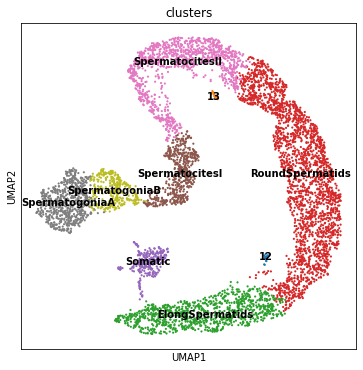

In [22]:
sc.plotting.umap(sample, color=['clusters'], legend_loc='on data')

We have two tiny clusters with very few cells. They are likely to be noisy datapoints pertaining to the large clusters. Since they are so small we will remove them, but first you can look at markers expression in those clusters below.

We can look at markers in a heatmap or a dotplot

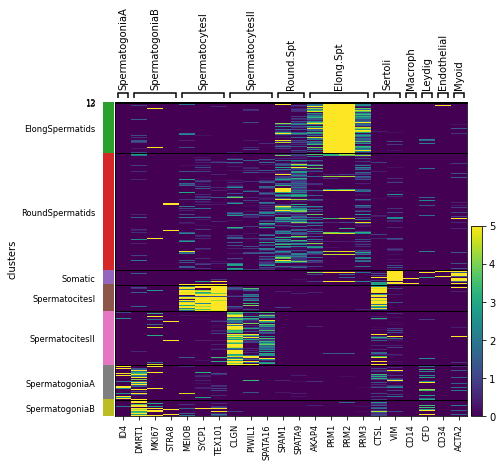

In [25]:
sc.pl.heatmap(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=5, layer='norm_sct')

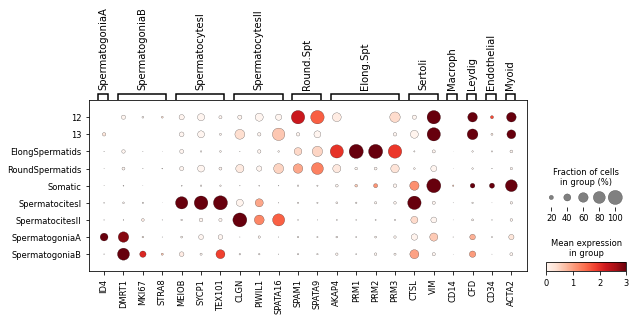

In [26]:
sc.pl.dotplot(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=3, layer='norm_sct')

Clusters 12 and 13 seem to be round spermatids and somatic cells. However, their tiny size makes them pretty much irrelevant for any analysis, and there is the risk that they are just noisier points. So we remove those clusters.

In [34]:
print(f'Cluster 12 has {str(sum(sample.obs["clusters"]=="12"))} cells')
print(f'Cluster 13 has {str(sum(sample.obs["clusters"]=="13"))} cells')

Cluster 12 has 15 cells
Cluster 13 has 13 cells


Remove cluster 12 and 13

In [35]:
sample = sample[ [i not in ['12','13'] for i in sample.obs['clusters'] ] ].copy()

save data

In [36]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.h5ad')

## Differential Expression (DE) analysis

We can do differential expression (DE) analysis to double check which genes are differentially expressed in each cluster. A gene is differentially expressed in a cluster when its expression in the cells of that cluster is statistically bigger than in all other cells. This is verified through a statistical test. 

Together with the gene names we also get p-values from the test, and a factor (`log-fold change`) telling the magnitude of how much the expression is larger than in other cells.

In [37]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

Apply the differential expression tool on the clusters for the top ten genes of each cluster. Save the results in `.uns[DE_clusters]`

In [38]:
sc.tl.rank_genes_groups(sample, groupby='clusters', key_added='DE_clusters', 
                        use_raw=False, n_genes=10, method='wilcoxon')

Access the list of names

In [39]:
pd.DataFrame(sample.uns['DE_clusters']['names'])

ElongSpermatids RoundSpermatids Somatic SpermatocitesI SpermatocitesII  \
0            TNP1          SPACA1   RPL10         TEX101           COPRS   
1            PRM1            EQTN  TMSB4X           LY6K          PPP3R2   
2       LINC01921          CLDND2   RPL41        HORMAD1         ZMYND10   
3            PRM2          FNDC11     B2M        C5orf58          MRPL34   
4           TEX37          TMEM89     VIM        C5orf47            LYAR   
5            GLUL          CCDC82    MYL6          SYCP3          SPINK2   
6      AC010255.3           ARMH2   CALD1        TMEM147            CLGN   
7           LELP1          SSMEM1  EEF1A1         PRSS21      AL133499.1   
8           HMGB4         C7orf61     MGP          TEX30          ASRGL1   
9            ESS2           HMGN1     FTL           TPTE        TMEM225B   

  SpermatogoniaA SpermatogoniaB  
0          RPS12           PTMA  
1           CCNI          HMGB1  
2         DNAJB6          CIRBP  
3          RPS19          TKTL1  
4           RPSA           NASP  
5         RPL18A           CFL1  
6          FKBP8           SMC3  
7        HNRNPDL          HMGN2  
8         EEF1B2            VCX  
9          YWHAB          YWHAE

Access the table including p-values (with suffix `_P` in each column) and log-fold change (with suffix `_L` in each column)

In [40]:
result = sample.uns['DE_clusters']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X

ElongSpermatids_N  ElongSpermatids_P  ElongSpermatids_L RoundSpermatids_N  \
0              TNP1                0.0           5.496218            SPACA1   
1              PRM1                0.0           5.231690              EQTN   
2         LINC01921                0.0           4.947102            CLDND2   
3              PRM2                0.0           5.084229            FNDC11   
4             TEX37                0.0           5.042583            TMEM89   
5              GLUL                0.0           3.823410            CCDC82   
6        AC010255.3                0.0           4.129203             ARMH2   
7             LELP1                0.0           3.589858            SSMEM1   
8             HMGB4                0.0           3.439270           C7orf61   
9              ESS2                0.0           4.287067             HMGN1   

   RoundSpermatids_P  RoundSpermatids_L Somatic_N      Somatic_P  Somatic_L  \
0                0.0           3.982206     RPL10  2.722742e-180   6.036248   
1                0.0           4.475617    TMSB4X  9.277510e-179   7.099336   
2                0.0           4.101193     RPL41  3.204055e-178   2.983494   
3                0.0           3.176443       B2M  1.491478e-177   6.528564   
4                0.0           3.663117       VIM  1.491478e-177   5.886309   
5                0.0           2.992516      MYL6  5.207174e-177   4.097159   
6                0.0           4.098052     CALD1  1.071437e-176   6.746485   
7                0.0           3.013259    EEF1A1  1.071437e-176   3.107935   
8                0.0           3.135094       MGP  1.106637e-176   7.276278   
9                0.0           2.982786       FTL  2.098130e-176   4.581300   

  SpermatocitesI_N  ...  SpermatocitesI_L  SpermatocitesII_N  \
0           TEX101  ...          6.611528              COPRS   
1             LY6K  ...          5.950183             PPP3R2   
2          HORMAD1  ...          3.927899            ZMYND10   
3          C5orf58  ...          4.420256             MRPL34   
4          C5orf47  ...          3.464285               LYAR   
5            SYCP3  ...          4.375456             SPINK2   
6          TMEM147  ...          3.205841               CLGN   
7           PRSS21  ...          3.583115         AL133499.1   
8            TEX30  ...          2.507236             ASRGL1   
9             TPTE  ...          5.114566           TMEM225B   

  SpermatocitesII_P  SpermatocitesII_L  SpermatogoniaA_N SpermatogoniaA_P  \
0               0.0           3.008929             RPS12              0.0   
1               0.0           2.904332              CCNI              0.0   
2               0.0           3.027187            DNAJB6              0.0   
3               0.0           3.705360             RPS19              0.0   
4               0.0           3.294042              RPSA              0.0   
5               0.0           2.468474            RPL18A              0.0   
6               0.0           3.269525             FKBP8              0.0   
7               0.0           3.735708           HNRNPDL              0.0   
8               0.0           2.342123            EEF1B2              0.0   
9               0.0           2.646122             YWHAB              0.0   

   SpermatogoniaA_L  SpermatogoniaB_N SpermatogoniaB_P  SpermatogoniaB_L  
0          3.348851              PTMA    5.878799e-193          4.665847  
1          5.027147             HMGB1    2.989841e-190          4.109627  
2          4.097905             CIRBP    1.134067e-181          4.153411  
3          3.600240             TKTL1    6.985088e-172          4.521289  
4          4.212831              NASP    3.808522e-171          3.740934  
5          4.936583              CFL1    2.252275e-169          2.260343  
6          2.213449              SMC3    3.943532e-169          4.240950  
7          3.815558             HMGN2    1.087712e-168          2.748033  
8          2.860381               

We can easily save the table in csv format. This can be opened in Excel.

In [41]:
!mkdir -p ../../Data/results

In [42]:
X.to_csv('../../Data/results/diff_expression_clusters.csv', header=True, index=False)

## Subclustering the data

We find subclusters of cells using markers for cell types that are found between late spermatogonia and spermatocites.

In [43]:
#Clusters to be subsetted
SUBGROUPS = ['SpermatogoniaB','SpermatocitesI','SpermatocitesII'] 

In [44]:
#Markers for the processes involved in late spermatogonia and spermatocites
markers['Leptotene'] = ['SYCE2','SCML1']
markers['Zygotene'] = ['LY6K', 'SYCP1']
markers['Pachytene'] = ['PIWIL1','CCDC112']
markers['Diplotene'] = ['OVOL2','CCNA1', 'CDK1','AURKA']

Let's look at the markers plottes only over the cells of the clusters `SpermatogoniaB`, `SpermatocitesI` and `SpermatocitesII`

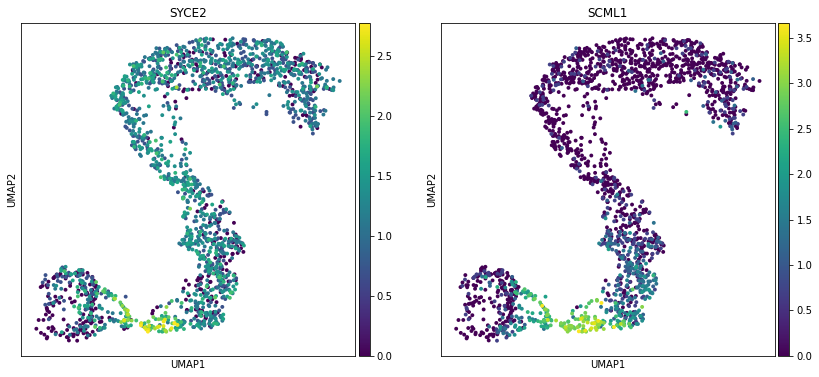

In [45]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Leptotene'])

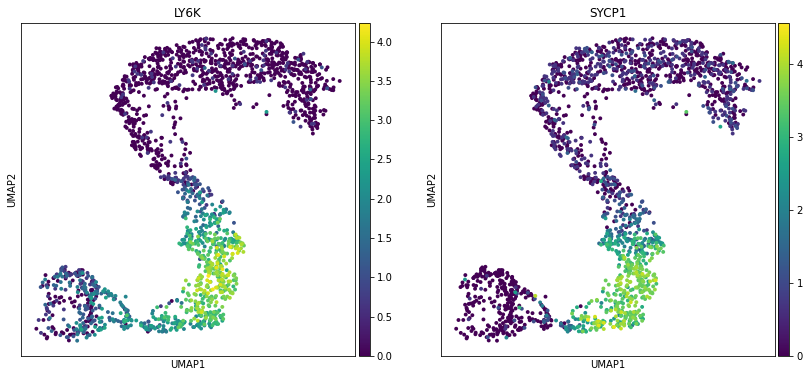

In [46]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Zygotene'])

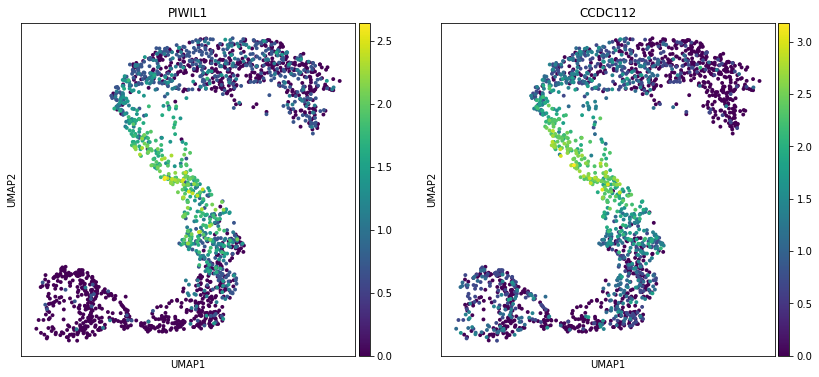

In [47]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Pachytene'])

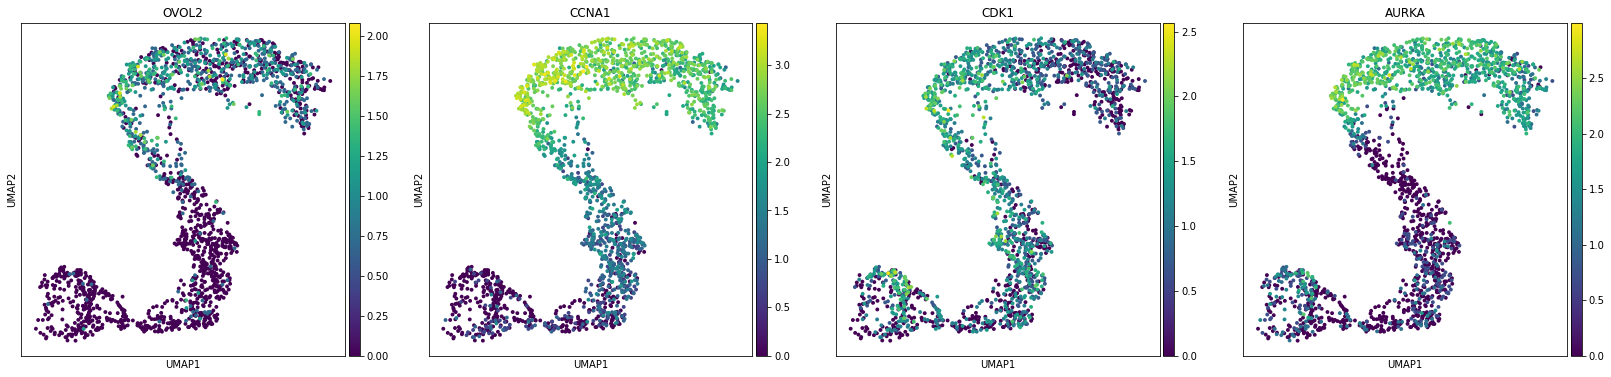

In [48]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Diplotene'])

We want to create new clusters in our dataset by starting from the old clustering. To do this we use the option `restrict_to`, where we write the name of the old clustering, and the name of which clusters we want to subset. Try to tune the resolution to have a proper number of clusters to rename.

In [88]:
sc.tl.leiden(sample, resolution=.4, key_added='clusters_spc',
            restrict_to=('clusters', SUBGROUPS),
            random_state=12345)

Let's look at the new clustering of `spermatogoniaB` and `spermatocites I/II`

Trying to set attribute `.uns` of view, copying.


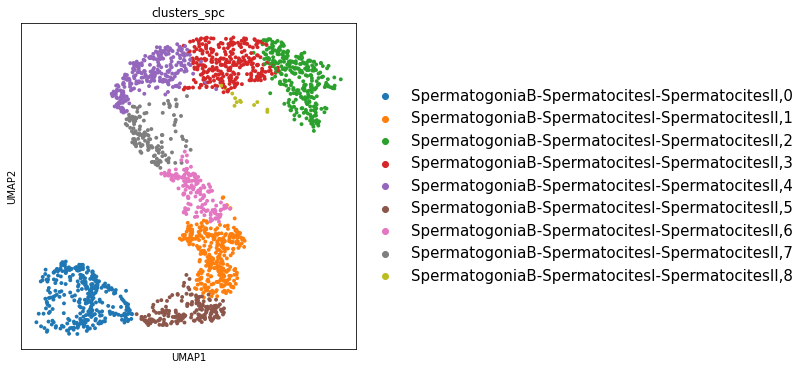

In [89]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_fontsize=15)

Names are very long. We keep only the numbers at the end

In [90]:
clusters = sample.obs['clusters_spc']
cluster_array = np.array(clusters)
split_array = [ i.split(',')[1] if ',' in i else i for i in cluster_array]
clusters = pd.Categorical(split_array)
sample.obs['clusters_spc']=clusters.copy()

Trying to set attribute `.uns` of view, copying.


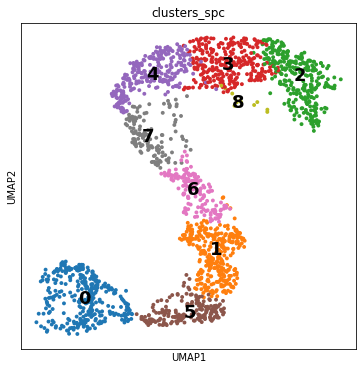

In [91]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_loc='on data', legend_fontsize=18)

Before renaming, we also want to look at the differentially expressed genes. We should be able to find at least some of the markers used in the plots. However, it can be that those do not appear because there are many other coexpressed genes with high expression values.

In [92]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

In [93]:
sc.tl.rank_genes_groups(sample, groupby='clusters_spc', key_added='DE_clusters_spc',
                        use_raw=False, n_genes=20, method='wilcoxon')

We can find some of the marker genes. For example `SCML1` for leptotene cells, `SYCP1` and `LY6K` for zygotene, `CCDC112` and `PIWIL1` for pachitene, `CCNA1` and `AURKA` for zygotene. 

In [94]:
pd.DataFrame(sample.uns['DE_clusters_spc']['names'])

0           1           2           3           4         5  \
0      PTMA     C5orf58       TBPL1  AL133499.1     CIAPIN1    ZCWPW1   
1     HMGB1        TPTE      CCDC42        GYG1      ASRGL1    TEX101   
2     CIRBP        LY6K       SNRPC       COPRS       CCNA1      SMC3   
3     TKTL1  AC044839.1        GYG1     ZMYND10        CLGN     SYCP3   
4      NASP       TDRG1      CAVIN3       SNRPC      PPP3R2    FMR1NB   
5      CFL1       STMN1      ETFRF1       ISOC2     NDUFAF3      PIGP   
6      SMC3   LINC01120  AL133499.1       CCNA1        RAE1  RAD51AP2   
7     HMGN2      TMEM99       ISOC2        LDHC        LDHC     SMC1B   
8       VCX      TEX101        LDHC      UQCR10  AL133499.1   HORMAD1   
9     YWHAE       GIHCG       CCNB2      CAVIN3      MRPL34      NPC2   
10  TRMT112     HORMAD1     ZC2HC1C        CLGN       AURKA      RHEB   
11    PRAME       H2AFZ    C16orf95       AURKA       COPRS     EIF1B   
12      NCL     ARL6IP1      TMIGD3      PPP3R2        LYAR   C5orf47   
13   CHCHD2       CALM2       ZPBP2     ZC2HC1C        GYG1    SDF2L1   
14   SDF2L1     TMEM147      FBXO25      MRPL34     ZMYND10     TEX30   
15    CENPH      PRSS21      CDRT15      ASRGL1      CAVIN3       DUT   
16    SNRPB        CTSL       H2AFJ       TBPL1       ISOC2     SYCP1   
17    RNPS1     C5orf47         UBB       PTTG1    SLC25A19     BUD23   
18     BTG3       SYCP1      GTF2A2        RAE1    TMPRSS12     TOP2A   
19   GAGE2A       TEX30       REXO5        LYAR       UBE2C    HIGD1A   

             6           7         8 ElongSpermatids RoundSpermatids Somatic  \
0   AL354707.1   STIM2-AS1       B2M            TNP1          SPACA1   RPL10   
1        GIHCG       RNFT1      GJA8            PRM1            EQTN  TMSB4X   
2         PHF7     CCDC112     CCNA1       LINC01921          CLDND2   RPL41   
3     C15orf48    C15orf48       MGP            PRM2          FNDC11     B2M   
4     SLC25A31       GMCL2    AKAP12           TEX37          TMEM89     VIM   
5   AC023491.2      COX7A2     CALD1            GLUL          CCDC82    MYL6   
6       TMEM99       CETN3  C16orf71      AC010255.3           ARMH2   CALD1   
7        CETN3      CAPNS1   CIAPIN1           LELP1          SSMEM1  EEF1A1   
8       MLLT10        CKS2    MRPL34           HMGB4         C7orf61     MGP   
9       SYNGR4      AKAP12     PLAC9            ESS2           HMGN1     FTL   
10  AC008771.1      PCDHB5      RAE1            OAZ3           LYZL6  RPL13A   
11     FAM207A       GSTM3   ZMYND10           OTUB2           AFG1L    CD63   
12         TPR      PIWIL1     RPL10          CEP170        C17orf50  MALAT1   
13      SPATA8  AC016747.1    TMSB4X           TEX44      AC022784.5  RPL27A   
14        CKLF      RPL39L       VIM        C10orf62          FAM24A   RPS4X   
15     CCDC112        TYMS      RGCC         P3R3URF         C4orf17  TMSB10   
16       CRNDE      PPP3R2       DCN       TEX36-AS1        C1orf185    RPS8   
17      BCAP29        MBD1     TXNIP           TSSK6            CIB4  RPL10A   
18       WDR54      MGAT4D    PABPC3       C20orf141           TFDP2   RPL39   
19      RPL39L        PHF7  CDK5RAP3           FNDC8           LYZL1    BEX3   

   SpermatogoniaA  
0           RPS12  
1            CCNI  
2          DNAJB6  
3           RPS19  
4            RPSA  
5          RPL18A  
6           FKBP8  
7         HNRNPDL  
8          EEF1B2  
9           YWHAB  
10         ZNF428  
11           RPS5  
12         TUBA1B  
13          EGFL7  
14          RPS21  
15         LYPLA1  
16          RPLP0  
17       PAFAH1B3  
18          RPS28  
19           FTH1

We can again look at p-values and log-fold changes

In [95]:
result = sample.uns['DE_clusters_spc']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

and save the table

In [96]:
X.to_csv('../../Data/results/diff_expression_subclusters.csv', header=True, index=False)

We can look at only the columns of a cluster from the large table so it is more readable

In [97]:
X[ ['7_N','7_L','7_P'] ]

7_N       7_L           7_P
0    STIM2-AS1  4.581324  1.220284e-78
1        RNFT1  3.418133  9.449980e-78
2      CCDC112  4.545506  4.108560e-76
3     C15orf48  3.201579  4.565801e-76
4        GMCL2  4.299609  6.822492e-75
5       COX7A2  1.705575  3.981169e-74
6        CETN3  4.212461  9.930327e-74
7       CAPNS1  2.851521  6.647057e-73
8         CKS2  3.643183  1.178306e-71
9       AKAP12  3.364398  1.960350e-70
10      PCDHB5  4.934474  3.911756e-70
11       GSTM3  1.581401  8.698700e-70
12      PIWIL1  3.756037  1.932467e-69
13  AC016747.1  3.473620  4.047163e-69
14      RPL39L  2.031874  4.047163e-69
15        TYMS  3.292274  4.081956e-69
16      PPP3R2  2.731762  4.431252e-69
17        MBD1  2.729477  6.427720e-69
18      MGAT4D  4.049344  7.167118e-69
19        PHF7  1.636368  8.553063e-69

We rename the new clusters. Write the names in the dictionary. Some of the clusters might still be `SpermatogoniaB` or `SpermatocitesII` as before.

In [98]:
clusters = pd.Categorical(sample.obs['clusters_spc'])

In [99]:
new_names = {
    '0':'SpermatogoniaB',
    '1':'Zygotene',
    '2':'Diplotene.1',
    '3':'Diplotene.2',
    '4':'Diplotene.3',
    '5':'Leptotene',
    '6':'Pachytene.2',
    '7':'Pachytene.1',
    '8':'Diplotene.5',
}

In [100]:
clusters=clusters.rename_categories(new_names)

In [101]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

In [102]:
sample.obs['clusters_spc']=clusters.copy()

Just a plot of the two clustering side by side

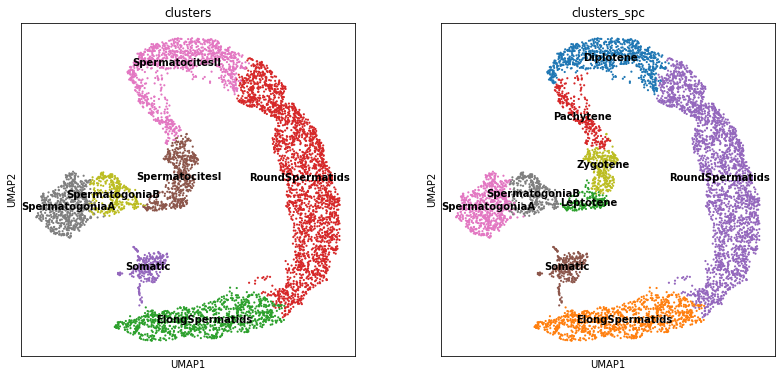

In [103]:
sc.plotting.umap(sample, color=['clusters','clusters_spc'], legend_loc='on data')

It isn't really clear how to rename clusters in somatic cells. We let them be called `somatic` without further specification

You can plot the correlation matrix of the clusters with a dendrogram tree on the left side. Note how round and elongated spermatids are largely separated from the rest of the data. Spermatogonias are very similar to each other and could maybe reduced into a single cluster. 

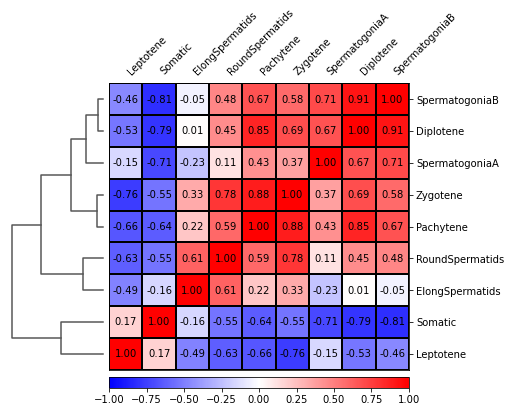

In [104]:
sc.pl.correlation_matrix(sample, groupby='clusters_spc', 
                         show_correlation_numbers=True)

Look at the proportion of each cell type in the data

In [105]:
#number of cells
sample.obs['clusters_spc'].value_counts()

RoundSpermatids    2385
ElongSpermatids    1032
Diplotene           868
SpermatogoniaA      701
SpermatogoniaB      335
Zygotene            319
Somatic             299
Pachytene           286
Leptotene           178
Name: clusters_spc, dtype: int64

In [106]:
#Percentage of cells
sample.obs['clusters_spc'].value_counts() / sample.shape[0] * 100

RoundSpermatids    37.248165
ElongSpermatids    16.117445
Diplotene          13.556146
SpermatogoniaA     10.947993
SpermatogoniaB      5.231923
Zygotene            4.982040
Somatic             4.669686
Pachytene           4.466656
Leptotene           2.779947
Name: clusters_spc, dtype: float64

finally, save the data

In [107]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.2.h5ad')

## Wrapping up

We have been showing how to simply identify potential cell clusters. At least in this dataset, the cells change from one type to another in a continuous process, so such a hard clustering does not completely reflect biological reality. However, it is a good approximation, as it is illustrated by the differentially expressed genes we could check in each cluster.
We introduced how to perform differential expression, and what are the useful values that we get from it (p-value of the test, magnitude of the gene expression compared to all other clusters). Finally, we subsetted the data into a more fine grained cell identification.